In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('../scripts')  # This points to the folder containing the .py file

from data_preprocessing import load_data, clean_data

df = load_data('../data/df_cleaned.csv')
df_claim = clean_data(df)  # ✅ This is correct – call the function and store the result

df_claim.head() 

,TotalClaims,TotalPremium,CalculatedPremiumPerTerm,SumInsured,CoverCategory,CoverType,CoverGroup,TermFrequency,ExcessSelected,StatutoryClass,...,AlarmImmobiliser,TrackingDevice,CapitalOutstanding,TransactionMonth,VehicleIntroDate,PostalCode,loss ratio,TransactionYear,Vehicle_age,Log_TotalClaims
203,2294.096491,0.000000,891.8912,208800.00,Own damage,Own Damage,Comprehensive - Taxi,Monthly,Mobility - Metered Taxis - R2000,Commercial,...,Yes,No,208800.0,2014-10-01,NaN,1982,NaN,2014,3,7.738094
284,2040.473684,21.929825,25.0000,0.01,Windscreen,Windscreen,Comprehensive - Taxi,Monthly,Mobility - Windscreen,Commercial,...,Yes,No,127300.0,2015-03-01,2005-06-01,1625,93.045600,2015,9,7.620937
1560,46492.211754,1213.889211,1383.8337,408000.00,Own damage,Own Damage,Comprehensive - Taxi,Monthly,Mobility - Metered Taxis - R2000,Commercial,...,Yes,No,0.0,2015-04-01,NaN,2066,38.300210,2015,1,10.747040
1779,26516.859649,645.017456,735.3199,206900.00,Own Damage,Own Damage,Comprehensive - Taxi,Monthly,Mobility - Taxi with value more than R100 000 ...,Commercial,...,Yes,No,0.0,2014-10-01,2007-04-01,4093,41.110298,2014,5,10.185536
1943,6140.350877,74.561404,85.0000,7000.00,Income Protector,Income Protector,Income Protector,Monthly,No excess,Commercial,...,Yes,No,0.0,2015-04-01,NaN,2066,82.352941,2015,1,8.722637


In [4]:
df_claim = df_claim.drop(columns=[ 'TotalPremium','loss ratio', 'TransactionYear',
                                   'VehicleIntroDate', 'TransactionMonth','loss ratio','MainCrestaZone',
                                  'SubCrestaZone','PostalCode' ], errors='ignore')

In [5]:
threshold = df_claim['TotalClaims'].quantile(0.99)
df_filtered = df_claim[df_claim['TotalClaims'] <= threshold]


print(f"Original rows: {df_claim.shape[0]}")
print(f"Filtered rows: {df_filtered.shape[0]}")
print(f"Removed rows: {df_claim.shape[0] - df_filtered.shape[0]}")

Original rows: 2788
Filtered rows: 2760
Removed rows: 28


In [6]:
categorical_cols = df_filtered.select_dtypes(include='object').columns.tolist()
df_encoded = pd.get_dummies(df_filtered, columns=categorical_cols, drop_first=True)

In [7]:

X = df_encoded[['Vehicle_age','SumInsured','Province_Free State',
 'Province_Gauteng',
 'Province_KwaZulu-Natal',
 'Province_Limpopo',
 'Province_Mpumalanga',
 'Province_North West',
 'Province_Northern Cape',
 'Province_Western Cape','VehicleType_Heavy Commercial',
 'VehicleType_Light Commercial',
 'VehicleType_Medium Commercial',
 'VehicleType_Passenger Vehicle',
 'VehicleType_Unknown_Category','MaritalStatus_Not specified',
 'MaritalStatus_Single',
 'MaritalStatus_Unknown_Category','NumberOfDoors']] 
y = df_encoded['TotalClaims']

from train_model import split_data

X_train, X_test, y_train, y_test = split_data(X, y)

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                 # Number of parameter settings sampled
    cv=3,                      # 3-fold cross-validation
    verbose=2,
    n_jobs=-1,                 # Use all processors
    scoring='neg_root_mean_squared_error',  # RMSE as scoring
    random_state=42
)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [9]:
best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Tuned Random Forest RMSE:", round(rmse, 4))
print("Tuned Random Forest R²:", round(r2, 4))
print("Best Parameters:", random_search.best_params_)

Tuned Random Forest RMSE: 25944.6006
Tuned Random Forest R²: 0.2987
Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}


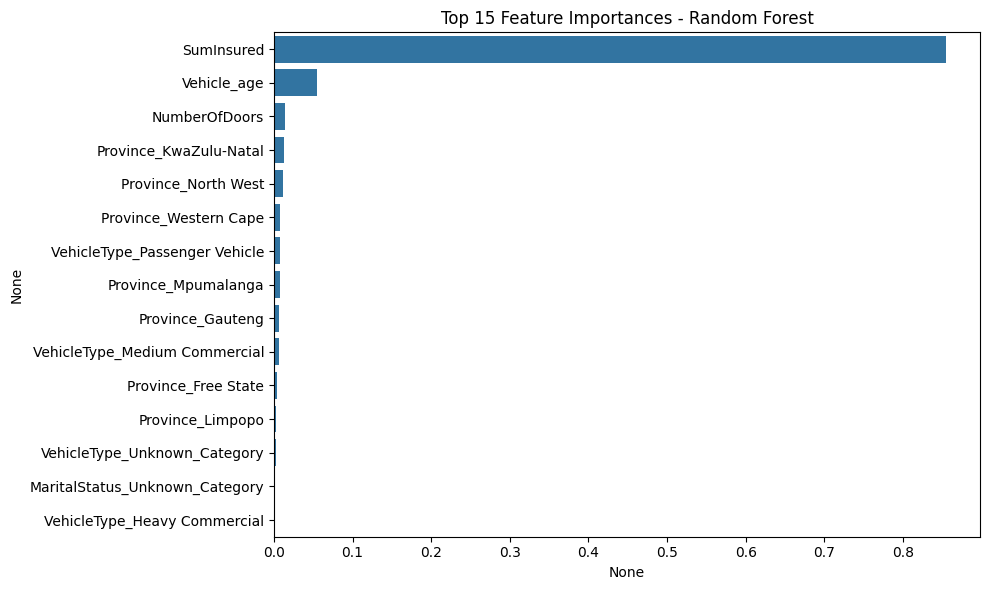

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = best_rf.feature_importances_
feature_names = X_train.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15])
plt.title("Top 15 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

c:\Users\techin\Insurance-analytics_week3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


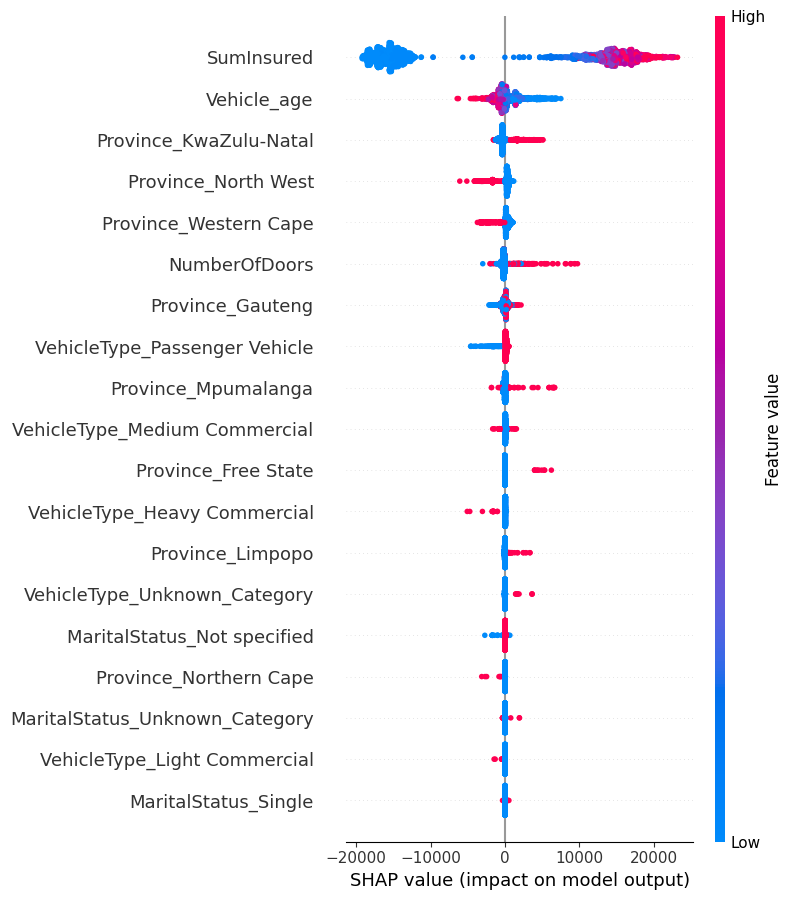

In [11]:
import shap
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)